# Susie finemapping analysis

In [1]:
setwd("~/project-gandalm/isoform_twas/eqtl_new/results/susie_finemap")
suppressMessages(library(data.table))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
library(tidyr)
library(wesanderson)

## Results summary-ALL
- We started with 10094 eGenes identified by FastQTL permutation pass for ALL ancestries with 90 HCP in covariates
- After filtering for CS purity: 
    - 7654 genes have non-low purity CS
    - 10671 unique CS
    - 122,050 unique variants in CS
- Of the 10671 CS:
    - 2423 contain exactly one SNP (strong candidates for causal variants)
    - 1291 contain exactly two SNPs
    - median size 5, mean 15.17, max1897
- Of the 7654 genes:
    - 5515 have exactly one CS
    - up to 8

### 1. all variants that belong to a non-low purity credible set

In [2]:
var_in_cs <- fread("mixed_ciseqtl_90hcp_perm.txt.gz", data.table = F)
dim(var_in_cs)

[1] 161929     17

#### How many eGenes got finemapped non-low purity credible sets?

In [4]:
length(unique(var_in_cs$phenotype_id))

[1] 7654

#### How many unique variants in all CS? 

In [5]:
length(unique(var_in_cs$variant_id))

[1] 122050

#### How many unique non-low purity CS?

In [6]:
length(unique(var_in_cs$cs_id))

[1] 10671

#### Sorted by chr and pos of genes

In [40]:
sorted_df_all <- fread("mixed_ciseqtl_90hcp_perm_purity_filtered.txt.gz", data.table = F)
dim(sorted_df_all)

[1] 161929     17

#### How many CS contain exactly one SNP?
**Note chr17 many genes with large CS.**

In [41]:
dim(sorted_df_all[!duplicated(sorted_df_all$cs_id),])

[1] 10671    17

In [42]:
cs_id_size_all <- sorted_df_all[!duplicated(sorted_df_all$cs_id),] %>% select(cs_id, cs_size, finemapped_region)

In [29]:
cs_id_size_all %>% filter(cs_size > 500)

cs_id,cs_size,finemapped_region
<chr>,<int>,<chr>
ENSG00000175395_L2,547,chr10:37265574-39265574
ENSG00000227540_L1,591,chr10:74012548-76012548
ENSG00000266918_L3,1897,chr17:42608942-44608942
ENSG00000264589_L1,1464,chr17:42973045-44973045
ENSG00000073969_L2,1469,chr17:43668034-45668034
ENSG00000185829_L4,1066,chr17:43657047-45657047
ENSG00000260075_L2,936,chr17:43450220-45450220
ENSG00000261575_L1,1067,chr17:43344402-45344402
ENSG00000263715_L1,1719,chr17:42697709-44697709


In [26]:
sum(cs_id_size_all$cs_size==1)
sum(cs_id_size_all$cs_size==2)

[1] 2423

[1] 1291

In [27]:
summary(cs_id_size_all$cs_size)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00    5.00   15.17   14.00 1897.00 

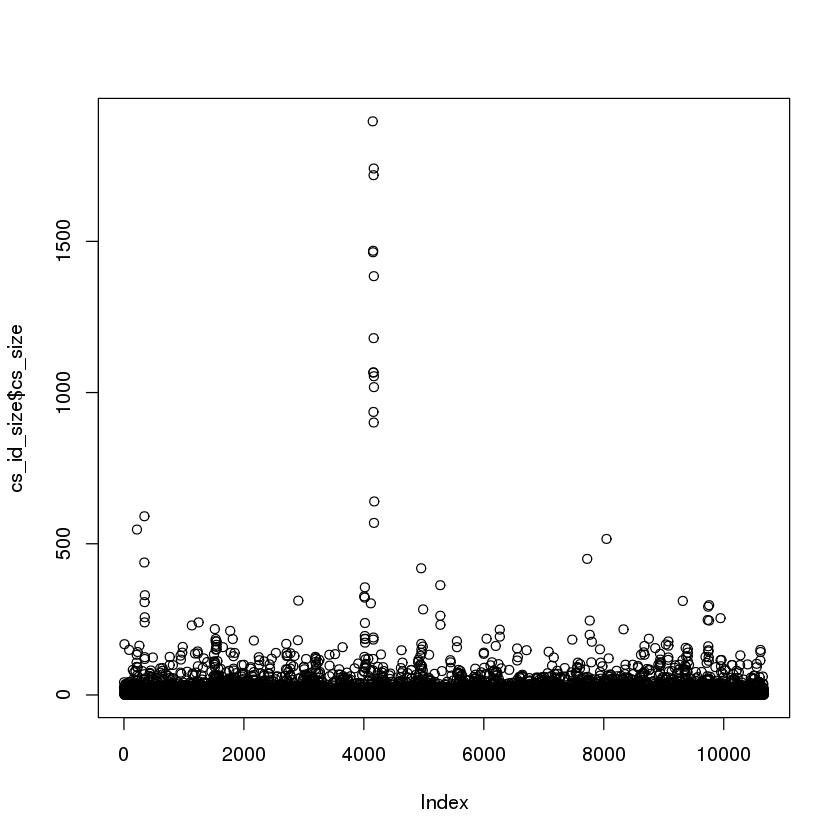

In [14]:
plot(cs_id_size_all$cs_size)

#### How many genes have exactly one CS?

In [43]:
genes_with_cs <- unique(sorted_df_all$phenotype_id)
df <- data.frame("gene" = genes_with_cs,
                 "cs_count" = NA)
for(i in 1:nrow(df)) {
    df[i,2] <- length(unique(sorted_df_all[sorted_df_all$phenotype_id == df[i,1],]$cs_id))
}

In [44]:
summary(df$cs_count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.394   2.000   8.000 

In [45]:
dim(df)

[1] 7654    2

In [46]:
sum(df$cs_count == 1)

[1] 5515

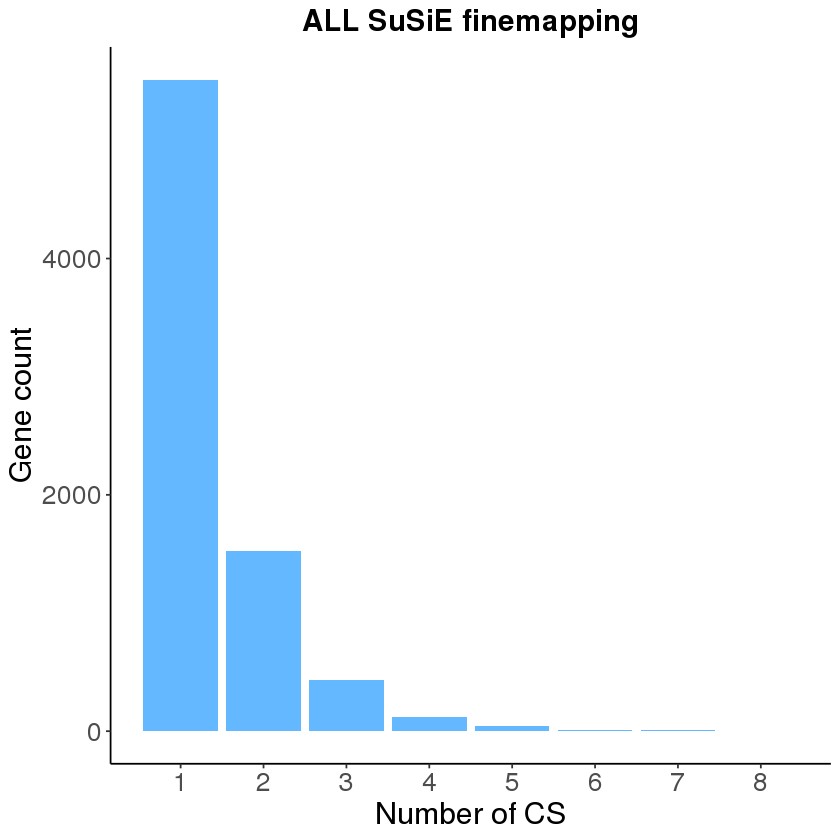

In [33]:
p <- ggplot(df, aes(x = cs_count)) +
  geom_bar(fill = "steelblue1") +
  scale_x_continuous(breaks = seq(1, 9, by = 1)) +
  labs(x = "Number of CS", y = "Gene count") +
  ggtitle("ALL SuSiE finemapping") +
  theme_classic() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5))
p

In [34]:
ggsave("../../figures/susie_num_cs.png", p, width = 6, height = 6)

#### Number of independent signals compared to conditional QTL mapping

In [7]:
conditional <- fread("../mixed_conditional_90hcp/conditional_top_variants.txt", data.table = F)

In [8]:
# filter for variant with backward p-value below threshold of this gene
conditional <- conditional %>% filter(V20 == 1)
# how many ranks of independent QTL each gene has?
df_conditional <- data.frame("gene" <- unique(conditional$V1),
                 "num_rank" <- NA)
for (i in 1:nrow(df_conditional)) {
  gene <- df_conditional[i,1]
  df_conditional[i,2] <- max(conditional[conditional$V1==gene,12]) + 1
}
names(df_conditional) <-c("gene","num_rank")

In [9]:
table(df_conditional$num_rank)


   1    2    3    4    5    6    7    8   10 
7312 2413  815  292   95   35   10    7    1 

In [9]:
# overlapping genes
df <- df %>% left_join(df_conditional, by = "gene")
head(df)

,gene,cs_count,num_rank
,<fct>,<int>,<dbl>
1,ENSG00000166024,1,1
2,ENSG00000119943,1,1
3,ENSG00000205740,1,1
4,ENSG00000119946,1,1
5,ENSG00000014919,1,1
6,ENSG00000233690,1,1


In [11]:
dim(df)

[1] 7654    3

In [11]:
sum(complete.cases(df))

[1] 7491

In [10]:
df <- df[complete.cases(df),]

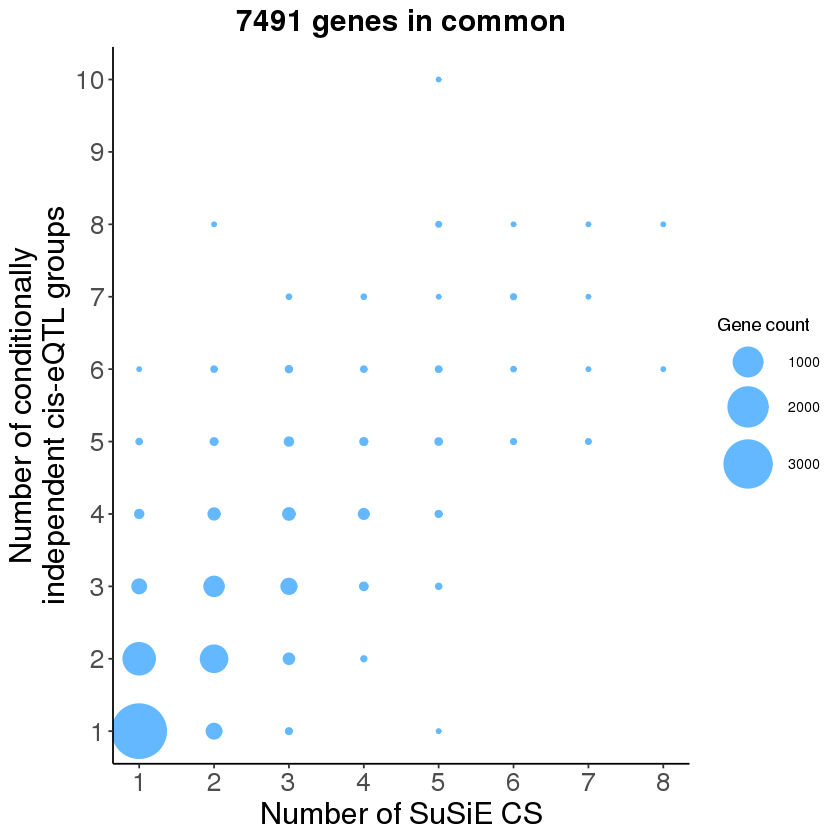

In [21]:
p <- ggplot(df, aes(x = cs_count, y = num_rank)) +
  geom_count(color = "steelblue1") +
#   geom_count(aes(color = ..n..), size=5) +
  scale_size(range = c(1, 15), "Gene count") + 
#   geom_hex() +
  labs(x = "Number of SuSiE CS", y = "Number of conditionally\nindependent cis-eQTL groups") +
  ggtitle("7491 genes in common") +
  theme_classic() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5)) +
  scale_x_continuous(breaks = seq(1,8,by=1)) +
  scale_y_continuous(breaks = seq(1,10,by=1)) 
p

In [22]:
ggsave("../../figures/susie_conditional.png", p, width=6, height=6)

In [20]:
cor(df$cs_count, df$num_rank, method = 'spearman')
cor(df$cs_count, df$num_rank, method = 'pearson')

[1] 0.6607808

[1] 0.7241307

#### sum of PIP in CS

In [30]:
cs_sum_pip <- sorted_df_all %>% group_by(cs_id) %>% summarise(sum_pip = sum(pip))
summary(cs_sum_pip)

`summarise()` ungrouping output (override with `.groups` argument)



    cs_id              sum_pip      
 Length:10671       Min.   :0.9500  
 Class :character   1st Qu.:0.9651  
 Mode  :character   Median :0.9791  
                    Mean   :0.9820  
                    3rd Qu.:0.9984  
                    Max.   :1.5440  

### 2. all credible sets (not filtered for purity)

In [14]:
cs <- fread("mixed_ciseqtl_90hcp_perm.cred.txt.gz", data.table = F)
dim(cs)

[1] 15153     9

In [15]:
head(cs)

,phenotype_id,cs_id,cs_index,finemapped_region,cs_log10bf,cs_avg_r2,cs_min_r2,cs_size,low_purity
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
1,ENSG00000273079,ENSG00000273079_L1,L1,chr12:13134890-15134890,2.141959084,1.000000000,1.000000e+00,1,FALSE
2,ENSG00000256751,ENSG00000256751_L1,L1,chr12:13720326-15720326,17.034654510,0.960079401,9.209719e-01,2,FALSE
3,ENSG00000182993,ENSG00000182993_L1,L1,chr12:13956599-15956599,32.321039529,1.000000000,1.000000e+00,1,FALSE
4,ENSG00000182993,ENSG00000182993_L3,L3,chr12:13956599-15956599,0.003084303,0.004807284,2.735455e-09,5552,TRUE
5,ENSG00000286107,ENSG00000286107_L1,L1,chr12:13958041-15958041,6.369879867,0.773075121,5.753129e-01,2,FALSE
6,ENSG00000256650,ENSG00000256650_L1,L1,chr12:14267631-16267631,1.507194318,0.819963722,5.982717e-01,4,FALSE


In [16]:
length(unique(cs$phenotype_id))

[1] 10093

In [17]:
table(cs$low_purity)


FALSE  TRUE 
10671  4482 

In [35]:
head(cs %>% filter(low_purity))

,phenotype_id,cs_id,cs_index,finemapped_region,cs_log10bf,cs_avg_r2,cs_min_r2,cs_size,low_purity
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
1,ENSG00000111261,ENSG00000111261_L1,L1,chr12:11503175-13503175,4.07944167,0.726510897,1.744063e-01,11,TRUE
2,ENSG00000255670,ENSG00000255670_L2,L2,chr12:11638286-13638286,0.45976964,0.003582169,4.231532e-10,2859,TRUE
3,ENSG00000111269,ENSG00000111269_L1,L1,chr12:11764760-13764760,2.16559198,0.568307145,9.618169e-02,25,TRUE
4,ENSG00000275963,ENSG00000275963_L5,L5,chr12:11801872-13801872,0.05347751,0.003353675,1.313858e-09,5537,TRUE
5,ENSG00000183150,ENSG00000183150_L7,L7,chr12:11849140-13849140,0.01117094,0.003360231,1.960944e-10,5668,TRUE
6,ENSG00000178878,ENSG00000178878_L2,L2,chr12:11878850-13878850,1.01661800,0.034086444,1.156653e-06,30,TRUE


**See code for low purity definition:**
```{r}
dplyr::mutate(
        cs_avg_r2 = mean.abs.corr^2,
        cs_min_r2 = min.abs.corr^2,
        low_purity = min.abs.corr < 0.5
      )
```

In [36]:
max(cs %>% filter(low_purity) %>% select(cs_min_r2))

[1] 0.2498847

In [37]:
min(cs %>% filter(!low_purity) %>% select(cs_min_r2))

[1] 0.2500968

### 3. all tested variants (very big file)

## EUR results
- We started with 5296 eGenes identified by FastQTL permutation pass for EUR with 50 HCP in covariates
- After filtering for CS purity: 
    - 4619 genes have non-low purity CS
    - 5559 unique CS
    - 95842 unique variants in CS
- Of the 5559 CS:
    - 1018 contain exactly one SNP (strong candidates for causal variants)
    - 560 contain exactly two SNPs
    - median size 7, mean 23.08, max 1945
- Of the 4619 genes:
    - 3835 have exactly one CS
    - up to 5

In [2]:
sorted_df_eur <- fread("eur_ciseqtl_50hcp_perm_purity_filtered.txt.gz", data.table = F)
dim(sorted_df_eur)

[1] 128302     17

In [37]:
# how many eGenes got finemapped non-low purity CS
length(unique(sorted_df_eur$phenotype_id))

[1] 4619

In [38]:
# how many unique variants in all CS
length(unique(sorted_df_eur$variant_id))

[1] 95842

In [48]:
# how many unique non-low purity CS
length(unique(sorted_df_eur$cs_id))

[1] 5559

In [29]:
# large CS
# how many CS contain exactly one/two SNP
cs_id_size_eur <- sorted_df_eur[!duplicated(sorted_df_eur$cs_id),] %>% select(cs_id, cs_size, finemapped_region)
sum(cs_id_size_eur$cs_size==1)
sum(cs_id_size_eur$cs_size==2)

[1] 1018

[1] 560

In [22]:
summary(cs_id_size_eur$cs_size)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00    7.00   23.08   22.00 1945.00 

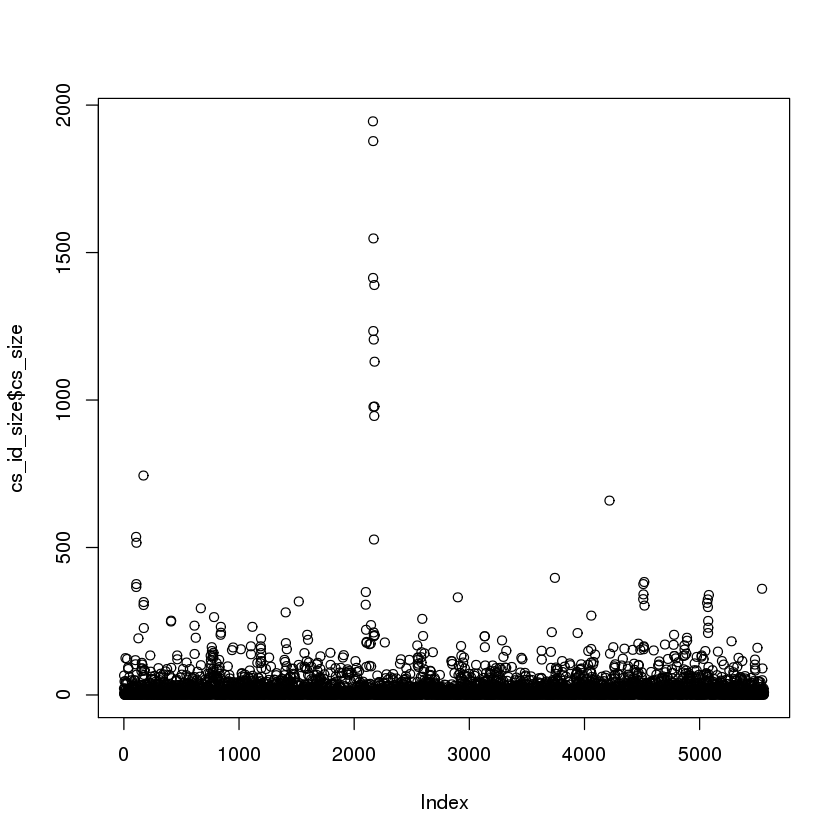

In [23]:
plot(cs_id_size_eur$cs_size)

In [49]:
# how many genes have exactly one CS
genes_with_cs <- unique(sorted_df_eur$phenotype_id)
df <- data.frame("gene" = genes_with_cs,
                 "cs_count" = NA)
for(i in 1:nrow(df)) {
    df[i,2] <- length(unique(sorted_df_eur[sorted_df_eur$phenotype_id == df[i,1],]$cs_id))
}
summary(df$cs_count)
sum(df$cs_count == 1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.204   1.000   5.000 

[1] 3835

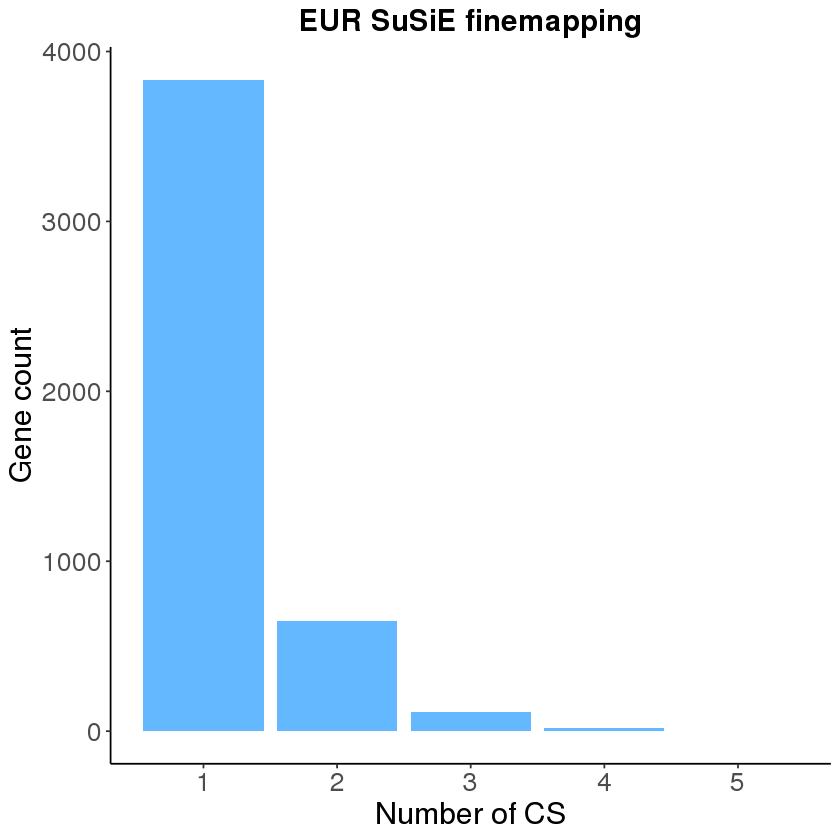

In [40]:
p <- ggplot(df, aes(x = cs_count)) +
  geom_bar(fill = "steelblue1") +
  scale_x_continuous(breaks = seq(1, 9, by = 1)) +
  labs(x = "Number of CS", y = "Gene count") +
  ggtitle("EUR SuSiE finemapping") +
  theme_classic() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5))
p

In [41]:
ggsave("../../figures/susie_num_cs_eur.png", p, width = 6, height = 6)

## AMR results
- We started with 3242 eGenes identified by FastQTL permutation pass for AMR with 15 HCP in covariates
- After filtering for CS purity: 
    - 2676 genes have non-low purity CS
    - 3009 unique CS
    - 55636 unique variants in CS
- Of the 3009 CS:
    - 520 contain exactly one SNP (strong candidates for causal variants)
    - 279 contain exactly two SNPs
    - median size 8, mean 31.53, max 2243
- Of the 2676 genes:
    - 2391 have exactly one CS
    - up to 4

In [3]:
sorted_df_amr <- fread("amr_ciseqtl_15hcp_perm_purity_filtered.txt.gz", data.table = F)
dim(sorted_df_amr)

[1] 94868    17

In [3]:
# how many eGenes got finemapped non-low purity CS
length(unique(sorted_df_amr$phenotype_id))

[1] 2676

In [4]:
# how many unique variants in all CS
length(unique(sorted_df_amr$variant_id))

[1] 55636

In [5]:
# how many unique non-low purity CS
length(unique(sorted_df_amr$cs_id))

[1] 3009

In [31]:
# how many CS contain exactly one/two SNP
cs_id_size_amr <- sorted_df_amr[!duplicated(sorted_df_amr$cs_id),] %>% select(cs_id, cs_size, finemapped_region)
sum(cs_id_size_amr$cs_size==1)
sum(cs_id_size_amr$cs_size==2)

[1] 520

[1] 279

In [32]:
summary(cs_id_size_amr$cs_size)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00    8.00   31.53   22.00 2243.00 

In [9]:
# how many genes have exactly one CS
genes_with_cs <- unique(sorted_df_amr$phenotype_id)
df <- data.frame("gene" = genes_with_cs,
                 "cs_count" = NA)
for(i in 1:nrow(df)) {
    df[i,2] <- length(unique(sorted_df_amr[sorted_df_amr$phenotype_id == df[i,1],]$cs_id))
}
summary(df$cs_count)
sum(df$cs_count == 1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.124   1.000   4.000 

[1] 2391

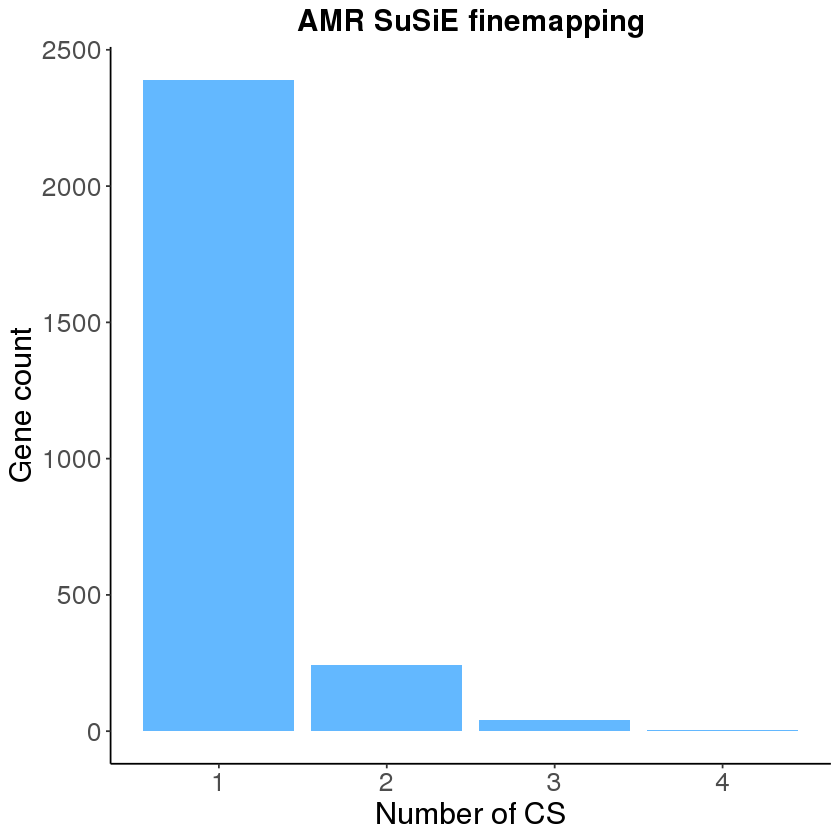

In [10]:
p <- ggplot(df, aes(x = cs_count)) +
  geom_bar(fill = "steelblue1") +
  scale_x_continuous(breaks = seq(1, 9, by = 1)) +
  labs(x = "Number of CS", y = "Gene count") +
  ggtitle("AMR SuSiE finemapping") +
  theme_classic() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5))
p

In [11]:
ggsave("../../figures/susie_num_cs_amr.png", p, width = 6, height = 6)

## AFR results
- We started with 1876 eGenes identified by FastQTL permutation pass for AFR with 25 HCP in covariates
- After filtering for CS purity: 
    - 1823 genes have non-low purity CS
    - 2288 unique CS
    - 27369 unique variants in CS
- Of the 2288 CS:
    - 617 contain exactly one SNP (strong candidates for causal variants)
    - 297 contain exactly two SNPs
    - median size 4, mean 15.85, max 1672
- Of the 1823 genes:
    - 1433 have exactly one CS
    - up to 4

In [4]:
sorted_df_afr <- fread("afr_ciseqtl_25hcp_perm_purity_filtered.txt.gz", data.table = F)
dim(sorted_df_afr)

[1] 36256    17

In [13]:
# how many eGenes got finemapped non-low purity CS
length(unique(sorted_df_afr$phenotype_id))

[1] 1823

In [14]:
# how many unique variants in all CS
length(unique(sorted_df_afr$variant_id))

[1] 27369

In [15]:
# how many unique non-low purity CS
length(unique(sorted_df_afr$cs_id))

[1] 2288

In [52]:
# how many CS contain exactly one/two SNP
cs_id_size_afr <- sorted_df_afr[!duplicated(sorted_df_afr$cs_id),] %>% select(cs_id, cs_size, finemapped_region)
sum(cs_id_size_afr$cs_size==1)
sum(cs_id_size_afr$cs_size==2)

[1] 617

[1] 297

In [17]:
summary(cs_id_size_afr$cs_size)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    4.00   15.85   11.25 1672.00 

In [18]:
# how many genes have exactly one CS
genes_with_cs <- unique(sorted_df_afr$phenotype_id)
df <- data.frame("gene" = genes_with_cs,
                 "cs_count" = NA)
for(i in 1:nrow(df)) {
    df[i,2] <- length(unique(sorted_df_afr[sorted_df_afr$phenotype_id == df[i,1],]$cs_id))
}
summary(df$cs_count)
sum(df$cs_count == 1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.255   1.000   4.000 

[1] 1433

In [22]:
dim(df)

[1] 1823    2

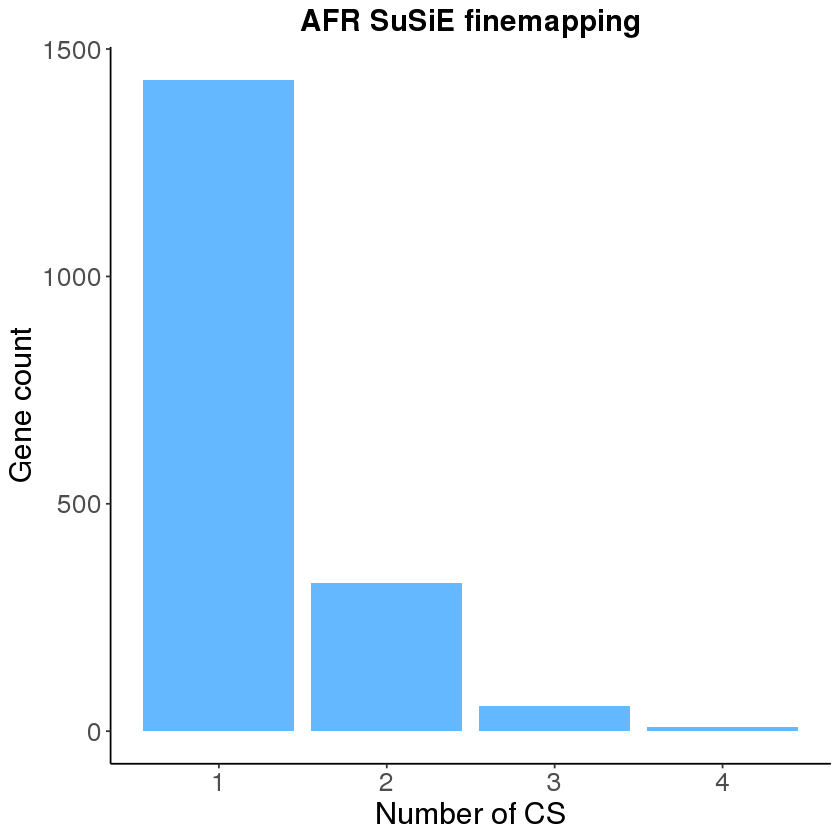

In [19]:
p <- ggplot(df, aes(x = cs_count)) +
  geom_bar(fill = "steelblue1") +
  scale_x_continuous(breaks = seq(1, 9, by = 1)) +
  labs(x = "Number of CS", y = "Gene count") +
  ggtitle("AFR SuSiE finemapping") +
  theme_classic() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5))
p

In [20]:
ggsave("../../figures/susie_num_cs_afr.png", p, width = 6, height = 6)

## Plot CS sizes

In [36]:
compare_df <- rbind(cs_id_size_all, cs_id_size_eur, cs_id_size_amr, cs_id_size_afr)

In [37]:
head(compare_df)

,cs_id,cs_size,finemapped_region
,<chr>,<int>,<chr>
1,ENSG00000166024_L1,24,chr10:98894380-100894380
5,ENSG00000119943_L1,42,chr10:99174938-101174938
47,ENSG00000205740_L1,4,chr10:34280-2034280
48,ENSG00000119946_L1,26,chr10:100089112-102089112
75,ENSG00000014919_L1,17,chr10:100491856-102491856
88,ENSG00000233690_L1,4,chr10:100457705-102457705


In [38]:
compare_df$Ancestry <- c(rep("ALL", nrow(cs_id_size_all)),
                         rep("EUR", nrow(cs_id_size_eur)),
                         rep("AMR", nrow(cs_id_size_amr)),
                         rep("AFR", nrow(cs_id_size_afr)))

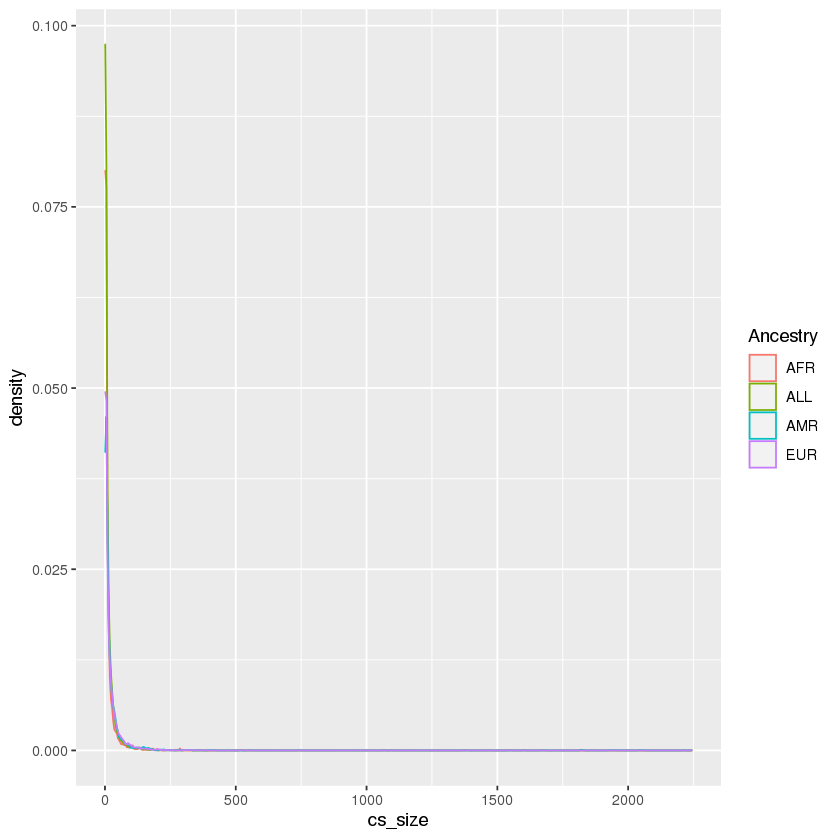

In [39]:
p <- ggplot(compare_df, aes(x = cs_size, color = Ancestry)) +
    geom_density()
p

## Ancestry eQTL effect size concordance
Tried filter for PIP(>.3, >.8, all). Only a small portion of gene-SNP pairs are in common. No such gene-SNP pairs: not shared by EUR, AMR high PIP groups and appear in only EUR/AMR high PIP groups. 

In [17]:
# all_high <- sorted_df_all %>% filter(pip > .8)
# eur_high <- sorted_df_eur %>% filter(pip > .3)
# amr_high <- sorted_df_amr %>% filter(pip > .3)
# afr_high <- sorted_df_afr %>% filter(pip > .3)
eur_high <- sorted_df_eur 
amr_high <- sorted_df_amr
afr_high <- sorted_df_afr

In [18]:
# dim(all_high)
dim(eur_high)
dim(amr_high)
dim(afr_high)

[1] 128302     17

[1] 94868    17

[1] 36256    17

In [19]:
eur_high <- eur_high %>% unite("gene_snp", phenotype_id, variant_id, sep = "-", remove = FALSE)
amr_high <- amr_high %>% unite("gene_snp", phenotype_id, variant_id, sep = "-", remove = FALSE)
afr_high <- afr_high %>% unite("gene_snp", phenotype_id, variant_id, sep = "-", remove = FALSE)

In [25]:
eur_amr <- eur_high %>%
    inner_join(amr_high, by = "gene_snp") %>%
    select(gene_snp, posterior_mean.x, posterior_mean.y)
eur_afr <- eur_high %>%
    inner_join(afr_high, by = "gene_snp") %>%
    select(gene_snp, posterior_mean.x, posterior_mean.y)
afr_amr <- afr_high %>%
    inner_join(amr_high, by = "gene_snp") %>%
    select(gene_snp, posterior_mean.x, posterior_mean.y)

In [26]:
dim(eur_amr)
dim(eur_afr)
dim(afr_amr)
sum(complete.cases(eur_amr))

[1] 25359     3

[1] 8459    3

[1] 13118     3

[1] 25359

In [27]:
eur_only_amr <- eur_high %>%
    filter(!gene_snp %in% amr_high$gene_snp) %>%
    select(gene_snp, posterior_mean)
names(eur_only_amr)[2] <- "posterior_mean.x"
eur_only_amr <- eur_only_amr %>% 
    left_join(amr_high, by = "gene_snp") %>%
    mutate(posterior_mean.y = posterior_mean) %>%
    select(gene_snp, posterior_mean.x, posterior_mean.y)
amr_only_eur <- amr_high %>%
    filter(!gene_snp %in% eur_high$gene_snp) %>%
    select(gene_snp, posterior_mean)
names(amr_only_eur)[2] <- "posterior_mean.y"
amr_only_eur <- amr_only_eur %>% 
    left_join(eur_high, by = "gene_snp") %>%
    mutate(posterior_mean.x = posterior_mean) %>%
    select(gene_snp, posterior_mean.x, posterior_mean.y)

In [28]:
dim(eur_only_amr)
dim(amr_only_eur)
sum(complete.cases(eur_only_amr))
sum(complete.cases(amr_only_eur))

[1] 102943      3

[1] 69509     3

[1] 0

[1] 0

In [29]:
eur_only_afr <- eur_high %>%
    filter(!gene_snp %in% afr_high$gene_snp) %>%
    select(gene_snp, posterior_mean)
names(eur_only_afr)[2] <- "posterior_mean.x"
eur_only_afr <- eur_only_afr %>% 
    left_join(afr_high, by = "gene_snp") %>%
    mutate(posterior_mean.y = posterior_mean) %>%
    select(gene_snp, posterior_mean.x, posterior_mean.y)
afr_only_eur <- afr_high %>%
    filter(!gene_snp %in% eur_high$gene_snp) %>%
    select(gene_snp, posterior_mean)
names(afr_only_eur)[2] <- "posterior_mean.y"
afr_only_eur <- afr_only_eur %>% 
    left_join(eur_high, by = "gene_snp") %>%
    mutate(posterior_mean.x = posterior_mean) %>%
    select(gene_snp, posterior_mean.x, posterior_mean.y)

In [30]:
dim(eur_only_afr)
dim(afr_only_eur)
sum(complete.cases(eur_only_afr))
sum(complete.cases(afr_only_eur))

[1] 119843      3

[1] 27797     3

[1] 0

[1] 0

In [31]:
afr_only_amr <- afr_high %>%
    filter(!gene_snp %in% amr_high$gene_snp) %>%
    select(gene_snp, posterior_mean)
names(afr_only_amr)[2] <- "posterior_mean.x"
afr_only_amr <- afr_only_amr %>% 
    left_join(amr_high, by = "gene_snp") %>%
    mutate(posterior_mean.y = posterior_mean) %>%
    select(gene_snp, posterior_mean.x, posterior_mean.y)
amr_only_afr <- amr_high %>%
    filter(!gene_snp %in% afr_high$gene_snp) %>%
    select(gene_snp, posterior_mean)
names(amr_only_afr)[2] <- "posterior_mean.y"
amr_only_afr <- amr_only_afr %>% 
    left_join(afr_high, by = "gene_snp") %>%
    mutate(posterior_mean.x = posterior_mean) %>%
    select(gene_snp, posterior_mean.x, posterior_mean.y)

dim(afr_only_amr)
dim(amr_only_afr)
sum(complete.cases(afr_only_amr))
sum(complete.cases(amr_only_afr))

[1] 23138     3

[1] 81750     3

[1] 0

[1] 0

In [78]:
eur_amr_df <- rbind(eur_amr, eur_only, amr_only)
eur_amr_df$group <- c(rep("EUR, AMR", nrow(eur_amr)),
                      rep("EUR only", nrow(eur_only)),
                      rep("AMR only", nrow(amr_only)))
eur_amr_df$group <- factor(eur_amr_df$group, levels = c("EUR, AMR", "EUR only", "AMR only"))

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1913 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1913 rows containing missing values (geom_point).”


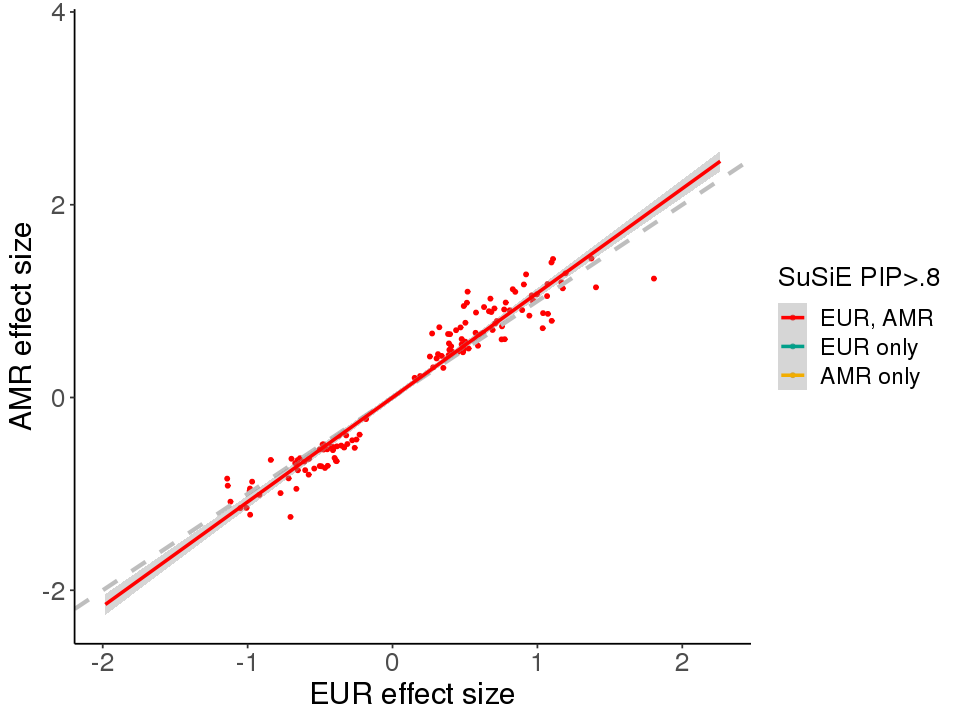

In [81]:
options(repr.plot.height = 6, repr.plot.width = 8)
# cols <- c("EUR only" = "#00A08A", "AMR only" = "#F2AD00", "EUR, AMR" = "#FF0000")

p <- ggplot(eur_amr_df, aes(x = posterior_mean.x, y = posterior_mean.y)) +
    geom_point(aes(color = group), alpha = 1, size = 1) +
    theme_classic() +
    labs(x = "EUR effect size", y = "AMR effect size") +
    scale_color_manual(values = wes_palette("Darjeeling1"), name = "SuSiE PIP>.8") +
#     scale_color_manual(values = cols, name = "Significant cis-eQTL") +
    theme(axis.title = element_text(size = 18),
          axis.text = element_text(size = 16),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14)) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "grey", size = 1.2) +
    geom_smooth(method = 'lm', aes(color = group), fullrange = TRUE)
p

In [82]:
sum(complete.cases(amr_only))

[1] 0